# Model Accuracy

Up until now, I've been using mostly qualitative, visual assessment to determine how well a model performed. I want to create a better metric. I'm thinking that a good metric will be the percentage of pixels correctly labelled; let's see how well it works.

In [1]:
import torch
import pandas as pd

import monai
from monai.transforms import (
    Compose,
    LoadNiftid,
    NormalizeIntensityd,
    AddChanneld,
    ToTensord,
    CenterSpatialCropd,
    ScaleIntensityRangePercentilesd,
    RandSpatialCropd
)
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference

import numpy as np

from lightning_modules import UNet3D

In [2]:
def get_model_metrics(model):
    data_df = pd.read_csv('/data/shared/prostate/yale_prostate/input_lists/MR_yale.csv')

    test_imgs = data_df['IMAGE'][295:].tolist()
    test_masks = data_df['SEGM'][295:].tolist()

    test_dicts = [{'image': image, 'mask': mask} for (image, mask) in zip(test_imgs, test_masks)]

    # Basic transforms
    data_keys = ["image", "mask"]
    data_transforms = Compose(
        [
            LoadNiftid(keys=data_keys),
            AddChanneld(keys=data_keys),
            ScaleIntensityRangePercentilesd(
                keys='image',
                lower=25,
                upper=75,
                b_min=-0.5,
                b_max=0.5
            )
        ]
    )

    test_dataset = monai.data.CacheDataset(
        data=test_dicts,
        transform=Compose(
            [
                data_transforms,
                ToTensord(keys=data_keys)
            ]
        ),
    )
    accuracies = np.array([])
    
    metrics = np.array([])
    dice_metric = DiceMetric(
        include_background=True,
    )
    
    for sample in test_dataset:
        test_image = sample['image'].unsqueeze(0).cuda()
        
        test_mask = sliding_window_inference(
            test_image,
            roi_size=[128, 128, 16],
            sw_batch_size=1,
            predictor=model,
            device=torch.device('cuda')
        )        
        test_mask = test_mask.argmax(1).cpu()
        
        metric = dice_metric(
            y_pred=test_mask.unsqueeze(0),
            y=sample['mask'].unsqueeze(0)
        )
        
        metrics = np.append(metrics, metric)
        accuracy = 1 - torch.sum(torch.abs(sample['mask'] - test_mask)) / sample['mask'].numel()
        accuracies = np.append(accuracies, accuracy)
        
    avg_accuracy = np.average(accuracies)
    median_accuracy = np.median(accuracies)
    avg_metric = np.average(metrics)
    
    return {
        'average': avg_accuracy,
        'median': median_accuracy,
        'dice_metric': avg_metric
    }

In [3]:
import glob
import CustomModels

In [4]:
def print_acc_metrics(model_class, checkpoint_path):
    model = model_class.load_from_checkpoint(checkpoint_path).cuda()
    model.eval()
    print(model.hparams.name)
    metrics = get_model_metrics(model)
    print('Average Accuracy: ', metrics['average'])
    print('Median Accuracy: ', metrics['median'])
    print('Average Dice: ', metrics['dice_metric'])

## 3D UNet

## Dice + Focal Loss

FileNotFoundError: [Errno 2] No such file or directory: '/data3/johnkim/kim-papademetris-lab/prostate/prostate_testing/models/7-24-2020_dicefocal_prostate/_ckpt_epoch_19.ckpt'

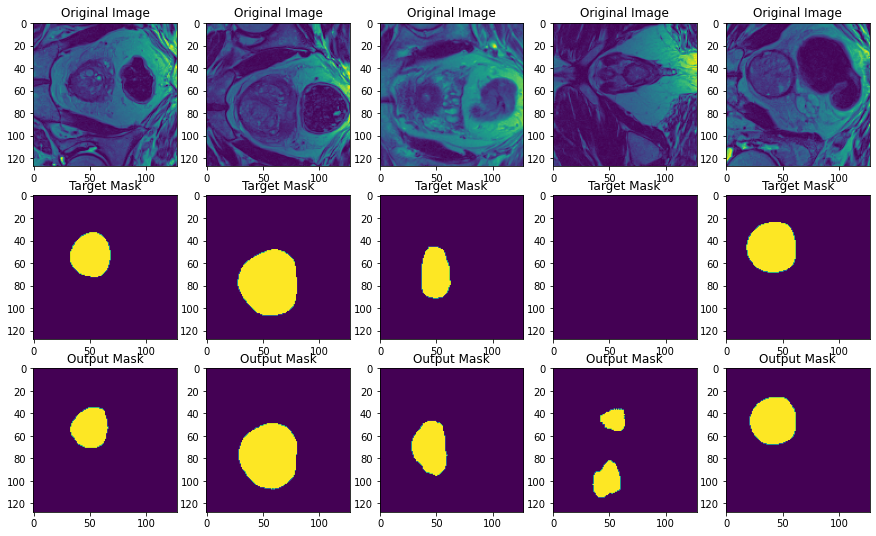

In [13]:
print_acc_metrics(CustomModels.UNet_DF, 'models/7-24-2020_dicefocal_prostate/_ckpt_epoch_19.ckpt')

## MaskGAN

In [ ]:
print_acc_metrics(CustomModels.MaskGAN, 'models/7-23-2020_MaskGAN_prostate/_ckpt_epoch_1964.ckpt')

## Pos Emphasized

In [ ]:
print_acc_metrics(CustomModels.UNet_DF, 'models/7-28-2020_pos_emphasized_prostate/_ckpt_epoch_39.ckpt')

## With Residuals

In [5]:
print_acc_metrics(UNet3D.UNet3D, 'models/2020-10-15_prostate/epoch=84-val_loss=0.06.ckpt')

Load and cache transformed data: 100%|██████████| 53/53 [00:00<00:00, 140074.42it/s]

2020-10-15_prostate


Average Accuracy:  0.9961941152248742
Median Accuracy:  0.9971408843994141
Average Dice:  0.8962929260055974


## Evaluation

In [7]:
import os
import glob
import random
import matplotlib.pyplot as plt

In [8]:
model = UNet3D.UNet3D.load_from_checkpoint('models/2020-10-15_prostate/epoch=84-val_loss=0.06.ckpt').cuda()
model.eval()
data_df = pd.read_csv('/data/shared/prostate/yale_prostate/input_lists/MR_yale.csv')
test_imgs = data_df['IMAGE'][295:].tolist()
test_masks = data_df['SEGM'][295:].tolist()
test_dicts = [{'image': image, 'mask': mask} for (image, mask) in zip(test_imgs, test_masks)]
# Basic transforms
data_keys = ["image", "mask"]
data_transforms = Compose(
    [
        LoadNiftid(keys=data_keys),
        AddChanneld(keys=data_keys),
        NormalizeIntensityd(keys="image"),
        RandSpatialCropd(
            keys=data_keys,
            roi_size=(128, 128, 16),
            random_size=False
        ),
    ]
)

test_dataset = monai.data.Dataset(
    data=test_dicts,
    transform=Compose(
        [
            data_transforms,
            ToTensord(keys=data_keys)
        ]
    )
)
test_samples = random.sample(range(len(test_dataset)), 5)
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
slice_depth = 8
for i in range(5):
    sample = test_dataset[test_samples[i]]
    axs[0, i].imshow(sample['image'][0, :, :, slice_depth])
    axs[0, i].set_title('Original Image')

    axs[1, i].imshow(sample['mask'][0, :, :, slice_depth])
    axs[1, i].set_title('Target Mask')

    test_image = sample['image'].unsqueeze(0).cuda() #.squeeze(4)
    test_mask = model(test_image)
    test_mask = test_mask.argmax(1).squeeze(0).cpu()
    axs[2, i].imshow(test_mask[:, :, slice_depth])
    axs[2, i].set_title('Output Mask')

plt.savefig('results/' + model.hparams.name + '.png')